<a href="https://colab.research.google.com/github/mateopolancecofficial/DeepLearningProjects/blob/main/Regression/Vineyard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from pickle import dump

In [179]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Input, 
    add,
    BatchNormalization
)

import kerastuner as kt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [180]:
strategy = None
if tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')

In [181]:
# set column names
columns = ['x0', 'x1', 'x2', 'x3', 'u']
features = ['x0', 'x1', 'x2', 'x3']
target = ['u']
# define ranges of all features
feature_ranges = {"x0": [1, 17], "x1": [-9, -4], "x2": [0, 3], "x3": [0, 50]}
# path to data source
source_path = "./Data/podaci.csv"
# split sizes for train, validation and test subsets
train_size, test_size, val_size = 0.8, 0.2, 0.2
# num of new samples
f_range = 100
# set batch_size
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [182]:
df = pd.read_csv(source_path, names=columns)

### Prepare datasets
All relevant functions are tested in exploration notebook.

In [183]:
def split_data(df: pd.DataFrame, features: list, target: list, train_size: float, 
               test_size: float, val_size: float):
  """
  Split dataset on train, test and validation subsets.
  :param df:          input pandas DataFrame
  :param features:    list of input features names
  :param target:      list of target column names
  :param train_size:  fraction of train size
  :param test_size:   fraction of test size
  :param val_size:    fraction of validation size
  :return:            dictionary, keys=names of DataFrame, columns=DataFrame
  """
  
  # shuffle dataset
  df = df.sample(frac = 1)
  
  # split on test and train set
  x_train, x_test, y_train, y_test = train_test_split(df[features], df[target],
                                     test_size=test_size, train_size=train_size)
    
  # split train set on train and validation subsets
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                      test_size=val_size, train_size=train_size)
  
  dataset_dict = {
      'x_train': x_train,
      'y_train': y_train,
      'x_val': x_val,
      'y_val': y_val,
      'x_test': x_test,
      'y_test': y_test
  }

  return dataset_dict

In [184]:
def cause_relevant_features(df: pd.DataFrame, features: list, f_range: int):
  """
  Cause new data based on calculated statistics.
  :param df:          input pandas DataFrame
  :param f_range:     int, num of new samples
  :return new_df:     pandas DataFrame with new data
  """

  new_data = {}

  for idx in range(len(features)):

    std = df[features[idx]].std()
    mean = df[features[idx]].mean()

    data_range = [mean - (1.5 * std), mean + (1.5 * std)]

    new_data[features[idx]] = np.random.uniform(data_range[0], data_range[1], f_range).reshape(f_range, 1).tolist()

  new_df = pd.DataFrame.from_dict(new_data)
  
  for fidx in range(len(features)):
    new_df[features[fidx]] = new_df[features[fidx]].map(lambda x: x[0])

  return new_df

In [185]:
def get_target_values(df: pd.DataFrame, target: list):
  """
  Return values of target variable based on input feature values.
  :param df:               pandas dataframe with input features
  :return target_result:   pandas dataframe with input features and target values
  """
  
  def calc_target_func(x0, x1, x2, x3):
    """
    Return target value.
    """

    return x0 + (x1**2) + x2 + (2*x3)
  

  df[target[0]] = df.apply(lambda row: calc_target_func(row['x0'], row['x1'], row['x2'], row['x3']), axis=1)

  return df

In [186]:
def create_extra_train_dataset(df: pd.DataFrame, df_new: pd.DataFrame):
  """
  Extend train dataset with new data.
  :param df:               pandas dataframe with input features
  :param df_new:           pandas dataframe with input augmented features
  :return df_result:       pandas dataframe with input features and target values
  """

  return pd.concat([df, df_new], axis=0).reset_index()[features + target]

In [187]:
def normalize_features(df: pd.DataFrame, features: list, target: list):
  """
  Use Yeo-Johnson transform to normalize input features and target variable.
  :param df:        dict with input pandas dataframes
  :param features:  list of input features names
  :param target:    list of target variables names
  :return out_data: dict, data = pandas dataframe with transformed data,
                          transformer = transformer objects
  """
  
  out_data = {'data': {}, 'transformers': []}
  transformers = []
  df_x = {}
  df_y = {}

  # normalize input data
  for key in list(df.keys()):

    if key == 'train_data':
      # fit input features
      transformer_f = PowerTransformer(method='yeo-johnson', standardize=True)
      x_trans = transformer_f.fit_transform(df[key][features])
      df_x[key] = pd.DataFrame(x_trans, columns=features)
      transformers.append(transformer_f)

      # fit input target
      transformer_t = PowerTransformer(method='yeo-johnson', standardize=True)
      y_trans = transformer_t.fit_transform(df[key][target])
      df_y[key] = pd.DataFrame(y_trans, columns=target)
      transformers.append(transformer_t)

    elif key == 'test_data':
      # transform input features
      x_trans = transformers[0].transform(df[key][features])
      df_x[key] = pd.DataFrame(x_trans, columns=features)

      # use test target variable
      y_trans = df[key][target]
      df_y[key] = pd.DataFrame(y_trans, columns=target)
    
    else:
      # transform input features
      x_trans = transformers[0].transform(df[key][features])
      df_x[key] = pd.DataFrame(x_trans, columns=features)

      # transform target variable
      y_trans = transformers[1].transform(df[key][target])
      df_y[key] = pd.DataFrame(y_trans, columns=target)

  # concatenate all transformed features dataframes with transformed target variables
  for key in list(df.keys()):
    out_data['data'][key] = pd.concat([df_x[key], df_y[key]], axis=1)
  
  out_data['transformers'] = transformers

  return out_data

In [188]:
def run_data_prep():
  """
    Prepare data sets.
  """
  df_data = {}
  df_extend_data = {}

  # split dataset on train, validation and test subsets
  dataset = split_data(df, features, target, train_size, test_size, val_size)

  # create train dataset
  x_train = dataset['x_train'].reset_index()[features]
  y_train = dataset['y_train'].reset_index()[target]
  train_data = pd.concat([x_train, y_train], axis=1)
  df_data['train_data'] = train_data

  # create validation dataset
  x_val = dataset['x_val'].reset_index()[features]
  y_val = dataset['y_val'].reset_index()[target]
  val_data = pd.concat([x_val, y_val], axis=1)
  df_data['val_data'] = val_data
  
  # create test dataset
  x_test = dataset['x_test'].reset_index()[features]
  y_test = dataset['y_test'].reset_index()[target]
  test_data = pd.concat([x_test, y_test], axis=1)
  df_data['test_data'] = test_data

  # normalize input data
  out_data = normalize_features(df_data, features, target)

  # create new dataset with more input samples
  new_data = cause_relevant_features(dataset['x_train'], features, f_range)
  new_data = get_target_values(new_data, target)
  new_data = new_data.reset_index()[features + target]
  train_new_data = create_extra_train_dataset(train_data, new_data)
  train_new_data = train_new_data.reset_index()[features + target]
  df_extend_data['train_data'] = train_new_data
  df_extend_data['val_data'] = val_data
  df_extend_data['test_data'] = test_data

  # normalize extended input data
  out_new_data = normalize_features(df_extend_data, features, target)

  return out_data, out_new_data


In [189]:
def create_input_datasets(df_data: dict, features: list, target: list, batch_size: int):
  """
  Create tensorflow datasets based on input dataframes for train, validation 
  and test subsets.
  param df_data: dictionary, keys=names of dataframes, columns=dataframes
  return:        dictionary, keys=names of datasets, columns=datasets
  """

  # create train dataset for input in tensorflow model
  train_dataset = tf.data.Dataset.from_tensor_slices((df_data['train_data'][features], 
                                                      df_data['train_data'][target]))
  train_dataset = train_dataset.batch(batch_size)
  train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  # create validation dataset for input in tensorflow model
  val_dataset = tf.data.Dataset.from_tensor_slices((df_data['val_data'][features], 
                                                    df_data['val_data'][target]))
  val_dataset = val_dataset.batch(batch_size)
  val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  # create validation dataset for input in tensorflow model
  test_dataset = tf.data.Dataset.from_tensor_slices((df_data['test_data'][features], 
                                                     df_data['test_data'][target]))
  test_dataset = test_dataset.batch(batch_size)
  test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

  datasets = {
      'train_dataset': train_dataset,
      'val_dataset': val_dataset,
      'test_dataset': test_dataset
  } 

  return datasets

In [190]:
out_data, out_new_data = run_data_prep()
datasets = create_input_datasets(out_data['data'], features, target, batch_size)
datasets_extended = create_input_datasets(out_new_data['data'], features, target, batch_size)

### Create model

In [191]:
# define loss functions
from tensorflow.keras import backend as K

def rmse():
  def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
  return root_mean_squared_error

def rmsle():
  def root_mean_squared_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(1+y_pred) - K.log(1+y_true))))
  return root_mean_squared_log_error

In [192]:
def model_builder(hp):
  """
  Regression model.
  """
    
  hp_units = hp.Int('units', min_value=len(features), max_value=len(features)*8, step=len(features))

  activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid'],
        default='relu'
    )
  
  # set input shape
  inputs = Input(shape=(len(features)), name="input_vineyard")
  
  # add skip connections
  x = Dense(units=len(features)*7, activation="relu",
           kernel_regularizer=tf.keras.regularizers.L2(1e-4),
           bias_regularizer=tf.keras.regularizers.L2(1e-4))(inputs)
    
  block_out_1 = Dense(units=len(features)*8, activation="relu",
                     kernel_regularizer=tf.keras.regularizers.L2(1e-4),
                     bias_regularizer=tf.keras.regularizers.L2(1e-4))(x)
  
  x = Dense(units=len(features)*8, activation="relu",
           kernel_regularizer=tf.keras.regularizers.L2(1e-4),
           bias_regularizer=tf.keras.regularizers.L2(1e-4))(block_out_1)

  x = Dense(units=len(features)*8, activation="relu",
           kernel_regularizer=tf.keras.regularizers.L2(1e-4),
           bias_regularizer=tf.keras.regularizers.L2(1e-4))(x)
  
  block_out_2 = add([x, block_out_1])
  
  # add batch normalization
  normalized = BatchNormalization()(block_out_2)

  x = Dense(units=hp_units, activation=activation,
           kernel_regularizer=tf.keras.regularizers.L2(1e-4),
           bias_regularizer=tf.keras.regularizers.L2(1e-4))(normalized)
    
  x = Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.1,
                max_value=0.5,
                default=0.25,
                step=0.1,
            ))(x)

  x = Dense(units=hp_units, activation=activation,
           kernel_regularizer=tf.keras.regularizers.L2(1e-4),
           bias_regularizer=tf.keras.regularizers.L2(1e-4))(x)
  
  # add dropout layers
  x = Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.1,
                max_value=0.5,
                default=0.25,
                step=0.1,
            ))(x)
    
  outputs = Dense(units=1)(x)

  model = keras.Model(inputs, outputs, name="vineyard_regressor")

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="mse",
                metrics=['mean_absolute_error'])

  return model

### Hyperparameter optimization

In [195]:
def set_hyperparameter_optimizer(strategy):
  """
  Set hyperparameter optimizer.
  """
  
  tuner = kt.Hyperband(
        hypermodel=model_builder,
        objective="val_mean_absolute_error",
        max_epochs=10,
        factor=2,
        hyperband_iterations=3,
        distribution_strategy=strategy,
        directory='HpResultsDir',
        project_name='vineyard_model')

  return tuner

In [196]:
# define early stop callback to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=10, mode='min')

In [197]:
tuner = set_hyperparameter_optimizer(strategy)

Tune hyperparameters on non-extended train dataset.

In [198]:
tuner.search(datasets['train_dataset'],
             validation_data=datasets['val_dataset'],
             epochs=10,
             callbacks=[stop_early])

# get optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 138 Complete [00h 00m 02s]
val_mean_absolute_error: 0.7831605672836304

Best val_mean_absolute_error So Far: 0.24229605495929718
Total elapsed time: 00h 03m 29s
INFO:tensorflow:Oracle triggered exit


### Training process
Training will be done on two different datasets (dataset, dataset_extended).

In [199]:
def plot_training_results(history, epochs):

  acc = history.history['mean_absolute_error']
  val_acc = history.history['val_mean_absolute_error']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training MAE')
  plt.plot(epochs_range, val_acc, label='Validation MAE')
  plt.legend(loc='upper right')
  plt.title('Training and Validation MAE')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

#### Process 1
dataset = dataset

In [200]:
model = tuner.hypermodel.build(best_hps)
epochs = 100
history_dat = model.fit(datasets['train_dataset'],
                        validation_data=datasets['val_dataset'],
                        epochs=epochs,
                        callbacks=[stop_early]
                       )

Epoch 1/100
4/4 [==============================] - 1s 46ms/step - loss: 0.8503 - mean_absolute_error: 0.7040 - val_loss: 0.3022 - val_mean_absolute_error: 0.4244
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 0.4477 - mean_absolute_error: 0.5423 - val_loss: 0.2905 - val_mean_absolute_error: 0.4344
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 0.2673 - mean_absolute_error: 0.4200 - val_loss: 0.1834 - val_mean_absolute_error: 0.3507
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 0.2344 - mean_absolute_error: 0.3511 - val_loss: 0.1664 - val_mean_absolute_error: 0.3334
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 0.1670 - mean_absolute_error: 0.3006 - val_loss: 0.1603 - val_mean_absolute_error: 0.3124
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 0.1532 - mean_absolute_error: 0.3009 - val_loss: 0.1556 - val_mean_absolute_error: 0.2862
Epoch 7/100
4/4 [================

4/4 [==============================] - 0s 4ms/step - loss: 0.0419 - mean_absolute_error: 0.1259 - val_loss: 0.0412 - val_mean_absolute_error: 0.1352
Epoch 52/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0438 - mean_absolute_error: 0.1278 - val_loss: 0.0344 - val_mean_absolute_error: 0.1121
Epoch 53/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0473 - mean_absolute_error: 0.1381 - val_loss: 0.0446 - val_mean_absolute_error: 0.1440
Epoch 54/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0451 - mean_absolute_error: 0.1336 - val_loss: 0.0371 - val_mean_absolute_error: 0.1275
Epoch 55/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0434 - mean_absolute_error: 0.1292 - val_loss: 0.0306 - val_mean_absolute_error: 0.1063
Epoch 56/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0413 - mean_absolute_error: 0.1292 - val_loss: 0.0360 - val_mean_absolute_error: 0.1257
Epoch 57/100
4/4 [=======================

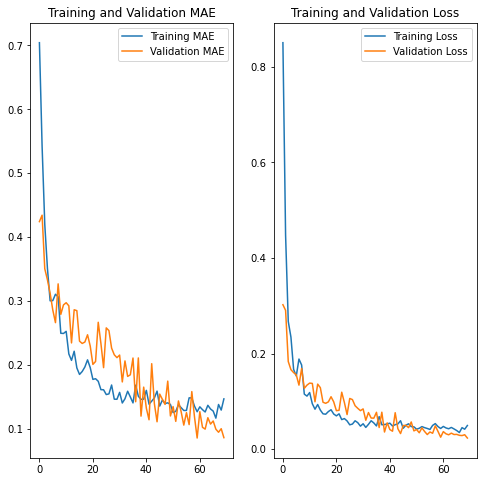

In [201]:
epochs = len(history_dat.history['loss'])
plot_training_results(history_dat, epochs)

#### Process 2
dataset = dataset_extended

In [202]:
model_extend = tuner.hypermodel.build(best_hps)
epochs = 100
history_dat_ext = model_extend.fit(datasets_extended['train_dataset'],
                                   validation_data=datasets_extended['val_dataset'],
                                   epochs=epochs,
                                   callbacks=[stop_early]
                                   )

Epoch 1/100
8/8 [==============================] - 1s 20ms/step - loss: 0.7394 - mean_absolute_error: 0.6589 - val_loss: 0.4054 - val_mean_absolute_error: 0.5243
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3265 - mean_absolute_error: 0.4407 - val_loss: 0.4511 - val_mean_absolute_error: 0.5588
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2928 - mean_absolute_error: 0.4398 - val_loss: 0.3231 - val_mean_absolute_error: 0.4640
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1682 - mean_absolute_error: 0.3118 - val_loss: 0.2621 - val_mean_absolute_error: 0.4093
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 0.2226 - mean_absolute_error: 0.3647 - val_loss: 0.2758 - val_mean_absolute_error: 0.4188
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 0.1550 - mean_absolute_error: 0.2845 - val_loss: 0.2600 - val_mean_absolute_error: 0.4109
Epoch 7/100
8/8 [================

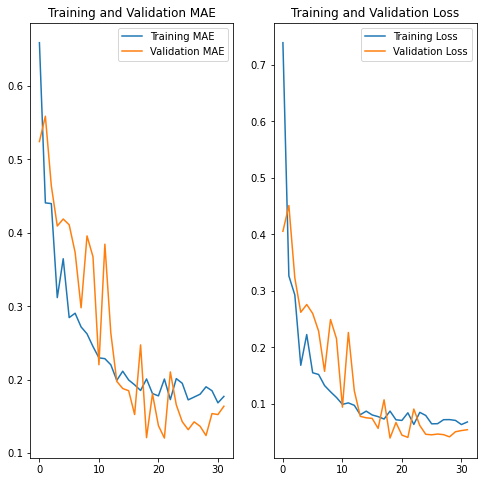

In [203]:
epochs = len(history_dat_ext.history['loss'])
plot_training_results(history_dat_ext, epochs)

### Calculate scores of both models on test sets

In [205]:
predictions = out_data['transformers'][1].inverse_transform(model.predict(datasets['test_dataset'])).reshape(-1, 1)
predictions_ext = out_new_data['transformers'][1].inverse_transform(model_extend.predict(datasets['test_dataset'])).reshape(-1, 1)

In [206]:
y_real = np.concatenate([y for x, y in datasets['test_dataset']], axis=0)

In [207]:
#Defining MAPE function
def mape(y_true, predictions):
    mape = np.mean(np.abs((y_true - predictions)/y_true))*100
    return mape

In [208]:
def calculate_scores(y_true, predictions, predictions_ext):
    """
    Calculate scores for both models.
    """
    estimators = {'BaseModel': 
              {
                  'mae': mean_absolute_error(y_true, predictions),
                  'mape': mape(y_true, predictions),
                  'r2_score': r2_score(y_true, predictions),
                  'y_predict': predictions
              }, 
              'ExtendModel':
              {
                  'mae': mean_absolute_error(y_true, predictions_ext),
                  'mape': mape(y_true, predictions_ext),
                  'r2_score': r2_score(y_true, predictions_ext),
                  'y_predict': predictions_ext
              }
             }
    
    return estimators
    

In [209]:
estimators = calculate_scores(y_real, predictions, predictions_ext)

In [210]:
def plot_regression_results(ax, y_true, y_pred, title, scores):
    """Scatter plot of the predicted vs true targets. """
    
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title
    ax.set_title(title)

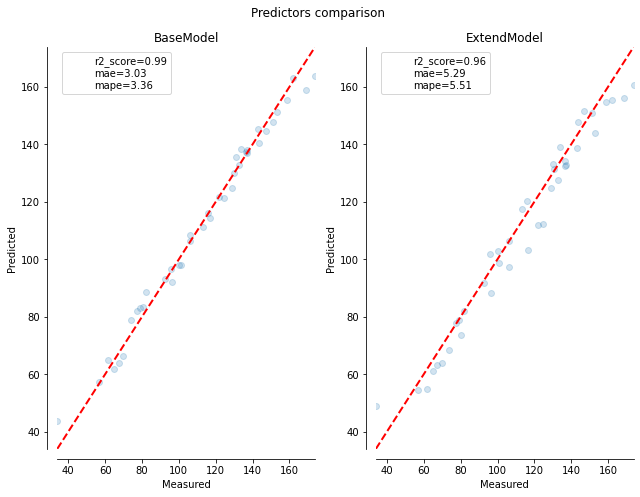

In [211]:
fig, axs = plt.subplots(1, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, name in zip(axs, list(estimators.keys())):
    
    plot_regression_results(
        ax, y_real, estimators[name]['y_predict'],
        name,
        (r'r2_score={:.2f}' + '\n' + r'mae={:.2f}' + '\n' + r'mape={:.2f}')
        .format(estimators[name]['r2_score'],
                estimators[name]['mae'],
                estimators[name]['mape']))

plt.suptitle('Predictors comparison ')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Conclusion
Both models shows great results with r2_score between 0.96 and 0.99. ExtendModel with more training data give lower mae and mape scores which means that we add more noise to model with adding new data.

### Save models

In [212]:
# save transformers
dump(out_data['transformers'][0], open('./Transformers/BaseModelFT.pkl', 'wb'))
dump(out_data['transformers'][1], open('./Transformers/BaseModelTT.pkl', 'wb'))
dump(out_new_data['transformers'][0], open('./Transformers/ExtendModelFT.pkl', 'wb'))
dump(out_new_data['transformers'][1], open('./Transformers/ExtendModelTT.pkl', 'wb'))

In [213]:
# save tensorflow models models
model.save('./TensorflowModels/BaseModel')
model_extend.save('./TensorflowModels/ExtendModel')

INFO:tensorflow:Assets written to: ./TensorflowModels/BaseModel\assets


c:\users\mateo.polancec\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./TensorflowModels/ExtendModel\assets


c:\users\mateo.polancec\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
